
# CNN - Object Detection - Part 2

**• DOMAIN:**
> Entertainment


**• CONTEXT:**
> Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

**• TASK:**
> Help to create an image dataset to be used by the AI team to build an image classifier data. Profile images of people are given.

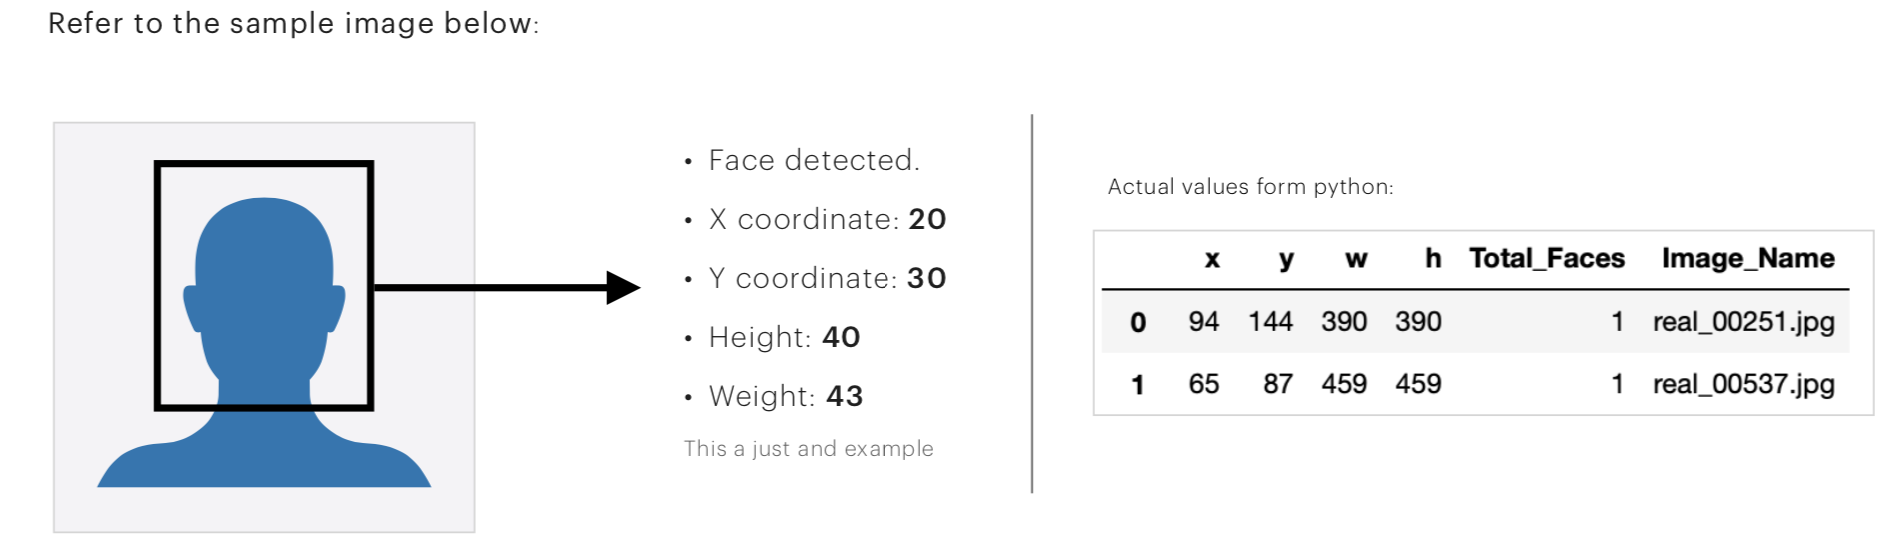

# (1) Import Python Libraries

#### Enable GPU for this Notebook

In [37]:
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")

import numpy as np
import pandas as pd
import os
from tqdm.notebook import trange, tqdm

import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

import random
import dlib
random.seed(0)

You are using TensorFlow version 2.4.1
You have a GPU enabled.


In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# (2) Import and load image files

## (2.1) Create path variables

In [39]:
project_path = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_2'
image_files = 'Part 2 - training images.zip'

## (2.2) Locate and extract the Zip file

In [40]:
images_zip_path = os.path.join(project_path, image_files)

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [41]:
## Get the Unzip Location in the drive
zip_dir_loc = z.filelist[0].filename.split("/")[0] 
zip_dir_loc

'training_images'

## (2.3) Create a list of all files in the UnZip folder

In [42]:
raw_img_file_names = [os.path.join(zip_dir_loc,i) for i in os.listdir(zip_dir_loc)]
raw_img_file_names[:5]

['training_images/real_00808.jpg',
 'training_images/real_00394.jpg',
 'training_images/real_00543.jpg',
 'training_images/real_00974.jpg',
 'training_images/real_00113.jpg']

## (2.4) Read all images from the folder into an array

In [43]:
img_list = []
for imgs in tqdm(raw_img_file_names):
  tst_img = cv2.imread(imgs)
  img_list.append(tst_img)
img_list = np.array(img_list)
display(Markdown(f"#### {img_list.shape}"))

#### (1091, 600, 600, 3)

#### Observations:
1. There are `1091` images in the folder.
2. Each one is a `600 X 600` `RGB` image.

## (2.5) Display the first 5 images in the list

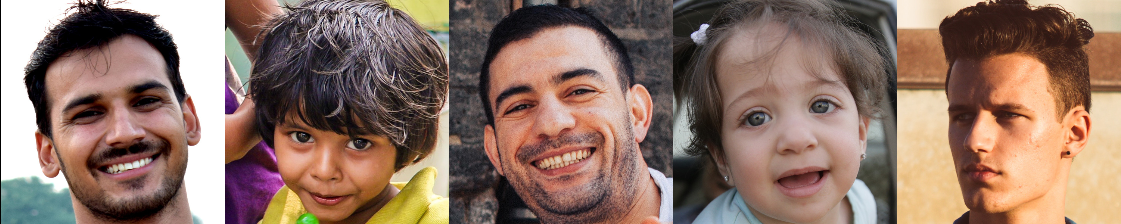

In [44]:
nums = 5
img = np.zeros((224,1,3))
for i in range(1,nums+1):
  image = cv2.resize(img_list[i],(224,224))
  img = np.concatenate([img,image],axis=1)
  if i % 5 == 0:
    cv2_imshow(img)
    img = np.zeros((224,1,3))
cv2_imshow(img)

# (3) Create helper functions

## (3.1) This function displays an image with the bounding bax given the filename and the bounding box attributes such as `x`, `y`, `w` and `h`

In [45]:
def test_bb(df,fname,title=""):

  tst_img = cv2.imread(fname)
  temp_df = df[df['Image_Name'] == fname]
  rect_img = []
  for rows in temp_df.index:
    x = df['x'][rows]
    y = df['y'][rows]
    w = df['w'][rows]
    h = df['h'][rows]
    cv2.rectangle(tst_img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(tst_img, title, (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
  cv2_imshow(tst_img)
  
  return

## (3.2) This function will output images from a list of file names 

In [46]:
def show_face(img_list,scale=1.0):

  for imgs in img_list:
    img = cv2.imread(imgs)
    img_w  = int(img.shape[1]*scale)
    img_h = int(img.shape[0]*scale)
    img = cv2.resize(img,(img_w,img_h))
    display(Markdown(f"#### {imgs}"))
    cv2_imshow(img)

  return

## (3.3) Helper fucntion to calculate the metrics

In [100]:
 def get_metrics(df,method=''):
   fp = df[df['Total_Faces'] > 1]['Image_Name'].nunique()
   fn = len(df[df['w'] == -1])
   tp = len(df[df['w'] != -1])
   precision = tp/(tp + fp)
   recall = tp/(tp + fn)
   f1 = 2*(precision * recall)/(precision + recall)
   return({'True_Positive':tp,
           'False_Positive':fp,
           'False_Negative':fn,
           'Precision':precision,
           'Recall':recall,
           'F1':f1,
           'Method':method})

##(3.4) Let's create some metrics.
> 1. True Positives : Face correctly detected.
> 2. False Positives : Face is not correctly detected. This means multiple faces are identified in a given image.
> 3. False Negatives : No face detected from a given image of a face.
> 4. Scores: Precision, Recall and  F1 Score

In [101]:
score_board = pd.DataFrame(columns=['Method','True_Positive','False_Positive','False_Negative','Precision','Recall','F1'])

# (4) Face  Detection using pre-trained models

##(4.1) Using Haar Cascade Classifier

> #### Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, “Rapid Object Detection using a Boosted Cascade of Simple Features” in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

### (4.1.1) Downloading the Haar cascade XML files along with the weights and layer file of the face detector of the DNN module that will be used by the OpenCV.

In [47]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2021-04-24 18:02:32--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.2’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2021-04-24 18:02:33 (13.7 MB/s) - ‘haarcascade_frontalface_default.xml.2’ saved [930127/930127]



### (4.1.2) Initialise the dataframe to hold the `x`, `y`, `w` and `h` from the bounding box and the file name.

In [87]:
haar_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
haar_img_box_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

### (4.1.3) Testing the Haar based Cascade Classifier with an image

### Bounding Box parameters are `x`:139, `y`:133, `width`:409, `height`:409

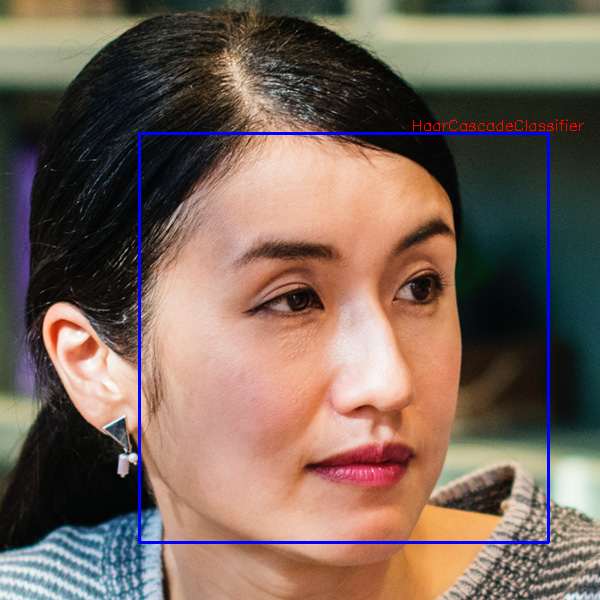

In [49]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

test_img = cv2.imread(raw_img_file_names[0])
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(grey,1.1,4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  cv2.putText(test_img, "HaarCascadeClassifier", (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))

# Display the output
display(Markdown(f"### Bounding Box parameters are `x`:{x}, `y`:{y}, `width`:{w}, `height`:{h}"))
cv2_imshow(test_img)


#### Observations:
> 1. The Haar based Cascade Classifier correctly detects the face

### (4.1.4) Looping through all images to get the bounding box

In [88]:
%%time
haar_undetected_images = []
haar_detected_images = []

for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    haar_detected_images.append(fnames)
    for (x,y,w,h) in faces:
      temp_dict = {'x':x, 
                  'y':y, 
                  'w':w,
                  'h':h, 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
  haar_img_box_df = haar_img_box_df.append(temp_dict,ignore_index=True)
display(Markdown(f"#### Detected faces for {len(haar_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(haar_undetected_images)} images"))

#### Detected faces for 930 images

#### Failed to detect faces for 161 images

CPU times: user 5min 50s, sys: 494 ms, total: 5min 50s
Wall time: 1min 37s


In [51]:
haar_img_box_df

x    y    w    h Total_Faces                      Image_Name
0     139  133  409  409           1  training_images/real_00808.jpg
1      89  103  452  452           1  training_images/real_00394.jpg
2     161  515   32   32           1  training_images/real_00543.jpg
3      47   72  462  462           1  training_images/real_00974.jpg
4      79  108  476  476           1  training_images/real_00113.jpg
...   ...  ...  ...  ...         ...                             ...
1006   57  193  384  384           1  training_images/real_00343.jpg
1007  120  210  369  369           1  training_images/real_00230.jpg
1008  434   76   97   97           2  training_images/real_00929.jpg
1009  105  202  382  382           2  training_images/real_00929.jpg
1010   99  181  400  400           1  training_images/real_00776.jpg

[1011 rows x 6 columns]

#### Observations:
> 1. The algorithm has detected `930` images with face or faces.
> 2. The algorithm has failed to detect `161` images with a face

### (4.1.5) Finding images with more than 1 face

In [52]:
haar_img_box_df[haar_img_box_df['Total_Faces'] > 1]

x    y    w    h Total_Faces                      Image_Name
6     187  168  365  365           2  training_images/real_00927.jpg
7      43  282  106  106           2  training_images/real_00927.jpg
11    147  143  424  424           2  training_images/real_00354.jpg
12     77  343   56   56           2  training_images/real_00354.jpg
35     89  104   57   57           2  training_images/real_01013.jpg
...   ...  ...  ...  ...         ...                             ...
974   100  217  332  332           3  training_images/real_00837.jpg
989    75   90  453  453           2  training_images/real_00605.jpg
990   244  386  159  159           2  training_images/real_00605.jpg
1008  434   76   97   97           2  training_images/real_00929.jpg
1009  105  202  382  382           2  training_images/real_00929.jpg

[156 rows x 6 columns]

#### Observation:
> 1. There are 156 rows that have detected more than 1 face. - False Positives.

### (4.1.6) Test an image and plot a bounding box around the face or faces

### (1) Correctly detected 1 face

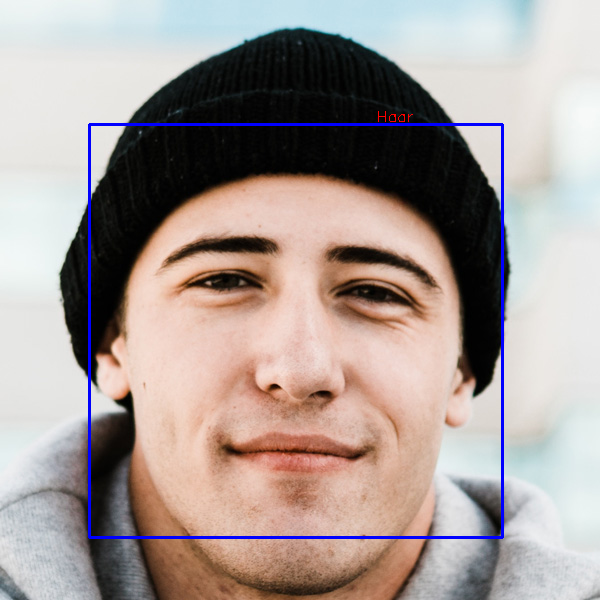

### (2) Incorrectly detected multiple faces

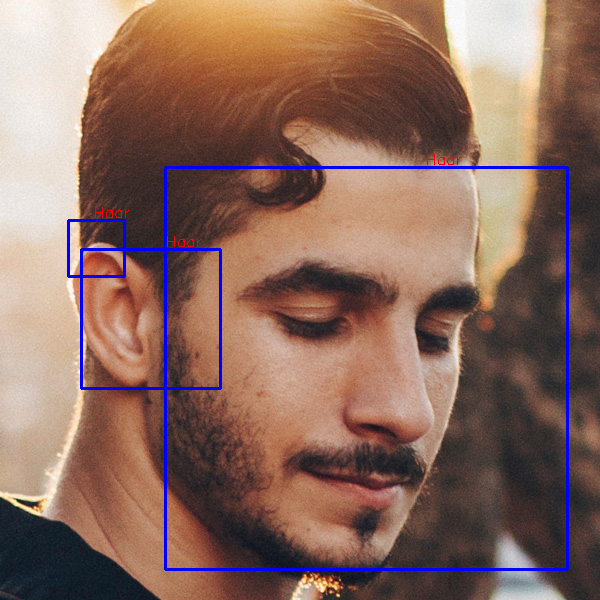

In [53]:
display(Markdown("### (1) Correctly detected 1 face"))
test_bb(haar_img_box_df,"training_images/real_00115.jpg",title="Haar")
display(Markdown("### (2) Incorrectly detected multiple faces"))
test_bb(haar_img_box_df,"training_images/real_00730.jpg",title="Haar")

#### Observation:
> 1.The algorithm might have incorrectly detected multiple faces in the 2nd image along with the correct one.

### (4.1.7) Display 5 images where face could not be detected

#### training_images/real_00020.jpg

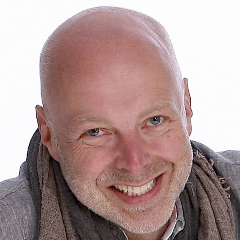

#### training_images/real_00005.jpg

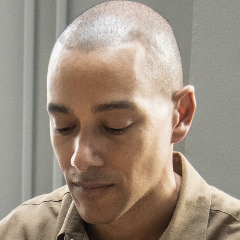

#### training_images/real_00729.jpg

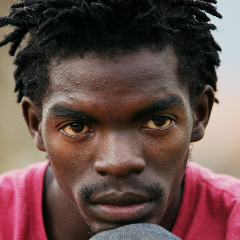

#### training_images/real_00228.jpg

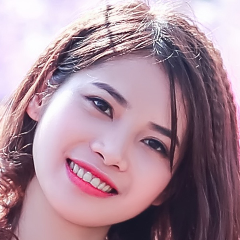

#### training_images/real_00435.jpg

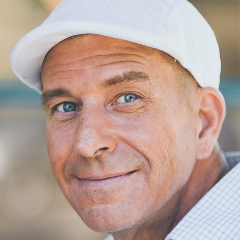

In [54]:
show_face(haar_undetected_images[-5:],scale=0.4)

In [102]:
score_board = score_board.append(get_metrics(haar_img_box_df,method='Haar'),ignore_index=True)
score_board

Method True_Positive False_Positive  ... Precision    Recall        F1
0   Haar           930             75  ...  0.925373  0.852429  0.887405

[1 rows x 7 columns]

#### Observation:
1. There is huge number of `False Negatives` and `False Positives.
2. The method has scored a good `88%` of F1 Score.
3. In most of the images where face could not be detected are case where,
  1. Face partailly covered.
  2. Face tilted such that the frontal face is not clearly visible.
  3. Face turned away such that the frontal is not clearly visible.
  4. Face zoomed such that it crops part of the face.
  5. Poor illumination or partially lit surfaces on the face.
4. We will next try a **DNN** approach and verify if that is able to all or most of the images.

## (4.2) Multi-task Cascaded Convolutional Networks (MTCNN)

#### Multi-task Cascaded Convolutional Networks (MTCNN)
https://medium.com/@iselagradilla94/multi-task-cascaded-convolutional-networks-mtcnn-for-face-detection-and-facial-landmark-alignment-7c21e8007923  
>It is a framework developed as a solution for both face detection and face alignment. The process consists of three stages of convolutional networks that are able to recognize faces and landmark location such as eyes, nose, and mouth.
>The paper proposes MTCNN as a way to integrate both tasks (recognition and alignment) using multi-task learning. In the first stage it uses a shallow CNN to quickly produce candidate windows. In the second stage it refines the proposed candidate windows through a more complex CNN. And lastly, in the third stage it uses a third CNN, more complex than the others, to further refine the result and output facial landmark positions.


### (4.2.1) Install the `mtcnn` package

In [55]:
!pip install mtcnn

### (4.2.2) Import the `mtcnn` library and create an instance of the same.

In [56]:
from mtcnn.mtcnn import MTCNN
mtcnn_det = MTCNN()

### (4.2.3) Testing an image for face detection

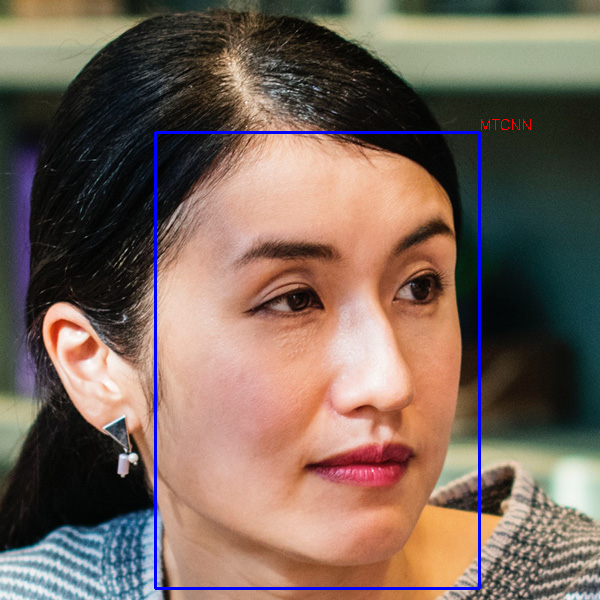

In [57]:
mtcnn_tst_img = cv2.imread(raw_img_file_names[0])
mt_cvt = cv2.cvtColor(mtcnn_tst_img,cv2.COLOR_BGR2RGB)
mt_faces = mtcnn_det.detect_faces(mt_cvt)
for face in mt_faces:
  mt_x, mt_y,mt_w,mt_h = face['box']
  cv2.rectangle(mtcnn_tst_img,(mt_x,mt_y),(mt_x + mt_w,mt_y + mt_h),(255,0,0),2)
  cv2.putText(mtcnn_tst_img, "MTCNN", (int((mt_x+mt_w)*1),mt_y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
cv2_imshow(mtcnn_tst_img)

#### Observation:
> 1. The face has been correctly detected. 
> 2. Also, that the bounding box is rectatngular in shape unlike the Haar based algorithm.

### (4.2.4) Initializing the dataframe to hold the attributes of the bounding box and looping through all images.

In [58]:
mtcnn_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
mtcnn_img_box_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

In [59]:
%%time
mtcnn_undetected_images = []
mtcnn_detected_images = []
for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  cvt_img = cv2.cvtColor(imgs,cv2.COLOR_BGR2RGB)
  faces = mtcnn_det.detect_faces(cvt_img)
  if len(faces) == 0:
    mtcnn_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    mtcnn_detected_images.append(fnames)
    for face in faces:
      temp_dict = {'x':face['box'][0], 
                  'y':face['box'][1], 
                  'w':face['box'][2],
                  'h':face['box'][3], 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      mtcnn_img_box_df = mtcnn_img_box_df.append(temp_dict,ignore_index=True)

display(Markdown(f"#### Detected faces for {len(mtcnn_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(mtcnn_undetected_images)} images"))

#### Detected faces for 1086 images

#### Failed to detect faces for 5 images

CPU times: user 8min 17s, sys: 21.3 s, total: 8min 38s
Wall time: 8min 12s


#### Observation:
> 1. The MTCNN has successfully detected face/faces in `1086` images.
> 2. The MTCNN has failed to detect face for `5` images unlike `161` in case of Haar based method.
> MTCNN has performed better than Haar based method but slower than Haar.

### (4.2.5) Display the dataframe 

In [60]:
mtcnn_img_box_df

x    y    w    h Total_Faces                      Image_Name
0     155  132  324  456           1  training_images/real_00808.jpg
1     134  122  341  433           1  training_images/real_00394.jpg
2     140  246  309  360           1  training_images/real_00543.jpg
3      99   85  372  461           1  training_images/real_00974.jpg
4     124  104  374  491           1  training_images/real_00113.jpg
...   ...  ...  ...  ...         ...                             ...
1098   86  134  399  486           1  training_images/real_00729.jpg
1099  124  164  318  433           1  training_images/real_00929.jpg
1100  108  102  362  451           1  training_images/real_00228.jpg
1101   92   74  381  487           1  training_images/real_00435.jpg
1102  127  175  383  424           1  training_images/real_00776.jpg

[1103 rows x 6 columns]

### (4.2.6) List all files that have been detected with more than 1 face.

In [61]:
display(mtcnn_img_box_df[mtcnn_img_box_df['Total_Faces'] > 1])
display(Markdown(f"#### Number of images with more than 1 face detected : {len(mtcnn_img_box_df[mtcnn_img_box_df['Total_Faces'] > 1])}"))

x    y    w    h Total_Faces                      Image_Name
16    175  130  308  441           2  training_images/real_00590.jpg
17    463  193   64   76           2  training_images/real_00590.jpg
29    142  115  351  476           2  training_images/real_01054.jpg
30    429   14  180  197           2  training_images/real_01054.jpg
109   139  148  316  432           2  training_images/real_00699.jpg
110    50  472   63   77           2  training_images/real_00699.jpg
225   133  121  319  416           2  training_images/real_00004.jpg
226   552  337   24   29           2  training_images/real_00004.jpg
383    56   72  428  491           2  training_images/real_00788.jpg
384   374    1   55   64           2  training_images/real_00788.jpg
402    69   26  472  596           2  training_images/real_01004.jpg
403   539  231   27   36           2  training_images/real_01004.jpg
488   151  149  387  449           2  training_images/real_00666.jpg
489   106  379   57   75           2  training_images/real_00666.jpg
550   109   79  366  486           2  training_images/real_01006.jpg
551   461  187   40   51           2  training_images/real_01006.jpg
593    93  134  348  393           2  training_images/real_00259.jpg
594   194  185  309  390           2  training_images/real_00259.jpg
599   145  130  329  430           2  training_images/real_00591.jpg
600    45  112   21   27           2  training_images/real_00591.jpg
680   101   64  368  484           2  training_images/real_00201.jpg
681   473  257   56   74           2  training_images/real_00201.jpg
740   119  158  317  429           2  training_images/real_00274.jpg
741   190   10  240  261           2  training_images/real_00274.jpg
803   103   65  361  491           2  training_images/real_00241.jpg
804    29  492   45   70           2  training_images/real_00241.jpg
864   147  152  296  390           2  training_images/real_00191.jpg
865   133  180   21   22           2  training_images/real_00191.jpg
952    95   91  366  431           2  training_images/real_00178.jpg
953    25  224   56   75           2  training_images/real_00178.jpg
981   112   73  385  492           2  training_images/real_01058.jpg
982   193   -5   68   80           2  training_images/real_01058.jpg
1013  170  184  321  425           2  training_images/real_00950.jpg
1014  117   28   51   59           2  training_images/real_00950.jpg

#### Number of images with more than 1 face detected : 34

### (1) Correctly detected 1 face

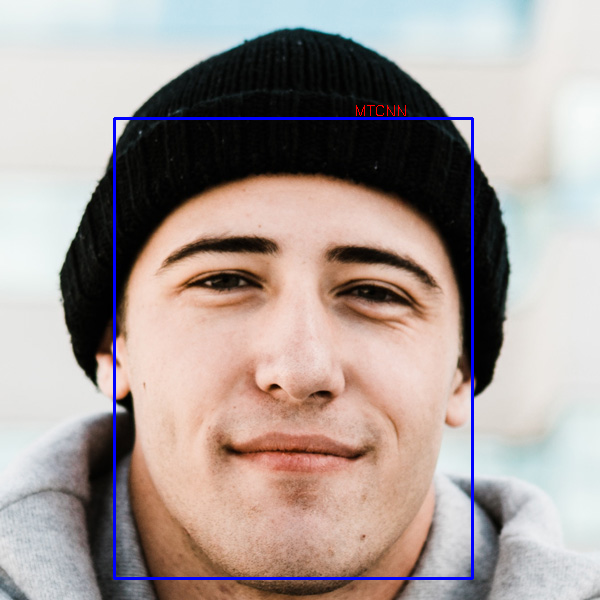

### (2) Correctly detected one face and incorrectly the other one

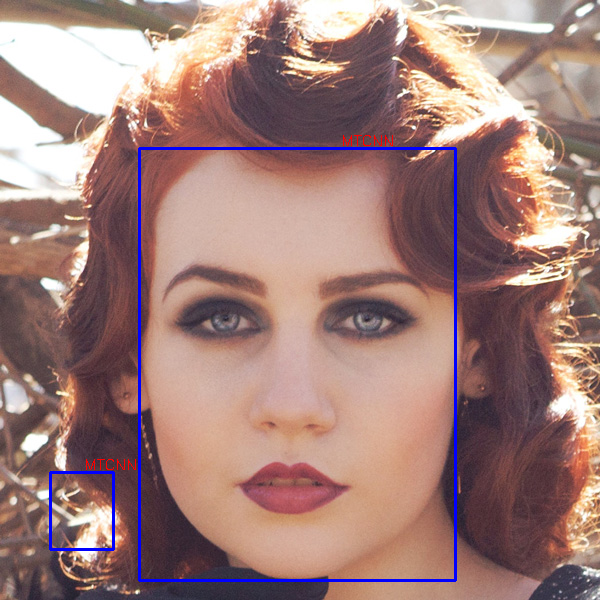

In [62]:
display(Markdown("### (1) Correctly detected 1 face"))
test_bb(mtcnn_img_box_df,"training_images/real_00115.jpg",title="MTCNN")
display(Markdown("### (2) Correctly detected one face and incorrectly the other one"))
test_bb(mtcnn_img_box_df,"training_images/real_00699.jpg",title="MTCNN")

#### Observation:
> 1. The MTCNN has correctly detected face from most of the images.
> 2. Ther are about 34 such images where more than 1 face is detected when compared to 156 in case of Haar based method.

### (4.2.7) Display all images where a face could not be detected.

#### training_images/real_00672.jpg

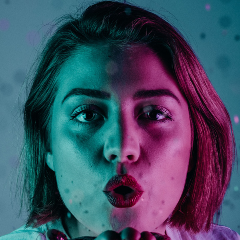

#### training_images/real_00692.jpg

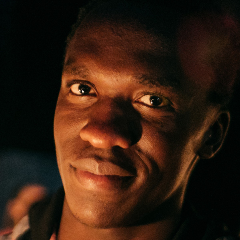

#### training_images/real_00951.jpg

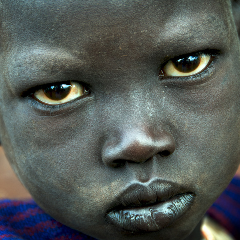

#### training_images/real_00818.jpg

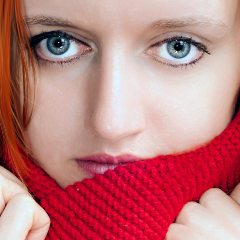

#### training_images/real_00696.jpg

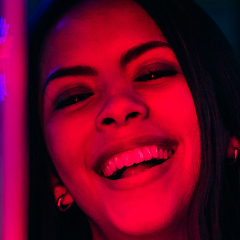

In [63]:
show_face(mtcnn_undetected_images,scale=0.4)

In [103]:
score_board = score_board.append(get_metrics(mtcnn_img_box_df,method='MTCNN'),ignore_index=True)
score_board

Method True_Positive False_Positive  ... Precision    Recall        F1
0   Haar           930             75  ...  0.925373  0.852429  0.887405
1  MTCNN          1103             17  ...  0.984821  1.000000  0.992353

[2 rows x 7 columns]

#### Observation:
> 1. The number of false positives has reduced significantly and without any false negatives.
> 2. The method scores a `99%` of F1 score which is an im,provement of  ~11%  over Haar based method 
> 2. There are about 5 images where a face could not be detected due to:
  1. Face partailly covered.
  2. Face zoomed such that it crops part of the face.
  3. Poor illumination or partially lit surfaces on the face.
> 3. The MTCNN has detected face in images where,
  1. Tilted face
  2. Face turned away.

## (4.3) Face Detection using Dlib _ CNN Based pre-trained model
http://dlib.net/cnn_face_detector.py.html

### (4.3.1) This is a helper fucntion to get the `Bounding Box` from the detector's output

In [64]:
def getBB(image, rect):

	x = max(0, rect.left())
	y = max(0, rect.top())
	x_end = min(rect.right(), image.shape[1])
	y_end = min(rect.bottom(), image.shape[0])

	w = x_end - x
	h = y_end - y
	return (x, y, w, h)

### (4.3.2) Download the model weights file

In [65]:
!wget "https://www.adrianbulat.com/downloads/dlib/mmod_human_face_detector.dat"

--2021-04-24 18:12:27--  https://www.adrianbulat.com/downloads/dlib/mmod_human_face_detector.dat
Resolving www.adrianbulat.com (www.adrianbulat.com)... 45.136.29.207
Connecting to www.adrianbulat.com (www.adrianbulat.com)|45.136.29.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729940 (713K) [application/octet-stream]
Saving to: ‘mmod_human_face_detector.dat.3’

mmod_human_face_det 100%[===================>] 712.83K   553KB/s    in 1.3s    

2021-04-24 18:12:30 (553 KB/s) - ‘mmod_human_face_detector.dat.3’ saved [729940/729940]



### (4.3.3) Display some 9 random samples of images with the bounding box.

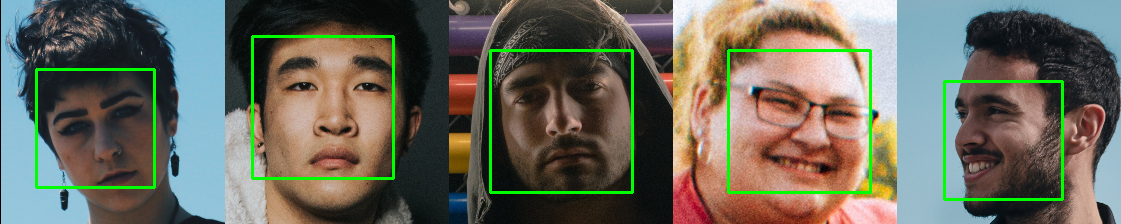

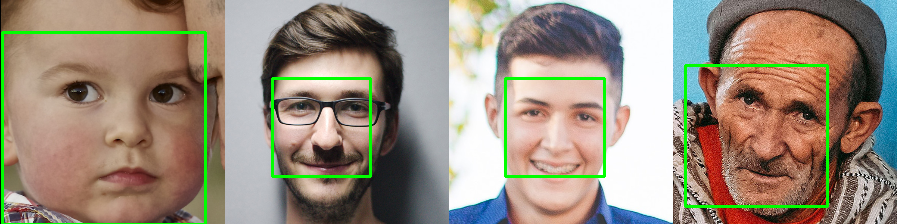

In [66]:
nums = 9

# detector = dlib.get_frontal_face_detector()
detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

img = np.zeros((224,1,3))

for nic in range(1,nums+1):
  image = cv2.imread(raw_img_file_names[random.randint(0,img_list.shape[0])])
  image = cv2.resize(image, (224,224))
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(rgb, 1)
  # print(len(rects))
  faces = [getBB(image, r.rect) for r in rects]
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

  img = np.concatenate([img,image],axis=1)
  if (nic % 5 == 0):
    cv2_imshow(img)
    img = np.zeros((224,1,3))

cv2_imshow(img)



#### Observation:
> 1. All faces are correctly detected.

### (4.3.4) Detect face/s and generate bounding box attributes for all images

In [67]:
dlib_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
dlib_img_box_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

In [68]:
%%time

dlib_undetected_images = []
dlib_detected_images = []
# detector = dlib.get_frontal_face_detector()
detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  cvt_img = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  # cvt_img = cv2.resize(image, (224,224))

  rects = detector(cvt_img, 1)
  if len(rects) == 0:
    dlib_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    dlib_detected_images.append(fnames)
    faces = [getBB(cvt_img, r.rect) for r in rects]
    for face in faces:
      temp_dict = {'x':face[0], 
                  'y':face[1], 
                  'w':face[2],
                  'h':face[3], 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      dlib_img_box_df = dlib_img_box_df.append(temp_dict,ignore_index=True)

display(Markdown(f"#### Detected faces for {len(dlib_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(dlib_undetected_images)} images"))

#### Detected faces for 1090 images

#### Failed to detect faces for 1 images

CPU times: user 1min, sys: 12.9 s, total: 1min 13s
Wall time: 1min 10s


#### Observation:
> 1. The model has detected faces in `1090` images and failed to do so for `1` image.
> 2. This the best we have seen between 3 diefferent methods.

### (4.3.5) Display the dataframe hoilding then bounding box attaributes

In [69]:
dlib_img_box_df

x    y    w    h Total_Faces                      Image_Name
0     132  148  422  423           1  training_images/real_00808.jpg
1     141  159  352  352           1  training_images/real_00394.jpg
2     128  259  294  293           1  training_images/real_00543.jpg
3      69  123  353  353           1  training_images/real_00974.jpg
4      89  148  423  423           1  training_images/real_00113.jpg
...   ...  ...  ...  ...         ...                             ...
1088  105  195  352  352           1  training_images/real_00729.jpg
1089  128  259  294  293           1  training_images/real_00929.jpg
1090   69  159  353  352           1  training_images/real_00228.jpg
1091   69  123  353  353           1  training_images/real_00435.jpg
1092   89  148  423  423           1  training_images/real_00776.jpg

[1093 rows x 6 columns]

### (4.3.6) Number of images where more than 2 faces were detected.

In [70]:
display(dlib_img_box_df[dlib_img_box_df['Total_Faces'] > 1])
display(Markdown(f"#### Number of images with more than 1 face detected : {len(dlib_img_box_df[dlib_img_box_df['Total_Faces'] > 1])}"))

x    y    w    h Total_Faces                      Image_Name
107    69  123  353  353           2  training_images/real_00041.jpg
108   119  219   82   82           2  training_images/real_00041.jpg
966    89   63  423  422           2  training_images/real_00688.jpg
967    65  174  204  204           2  training_images/real_00688.jpg
1050   69  230  353  353           2  training_images/real_00944.jpg
1051  111  286   82   82           2  training_images/real_00944.jpg

#### Number of images with more than 1 face detected : 6

### (1) Correctly detected 1 face

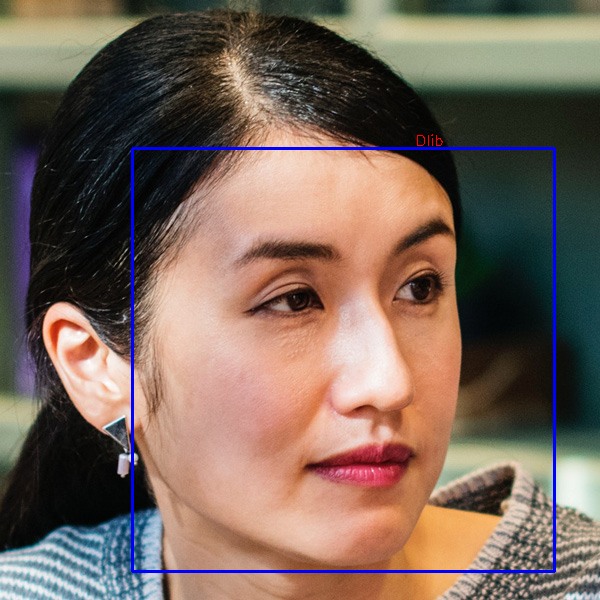

### (2) Incorrectly detected 2 face

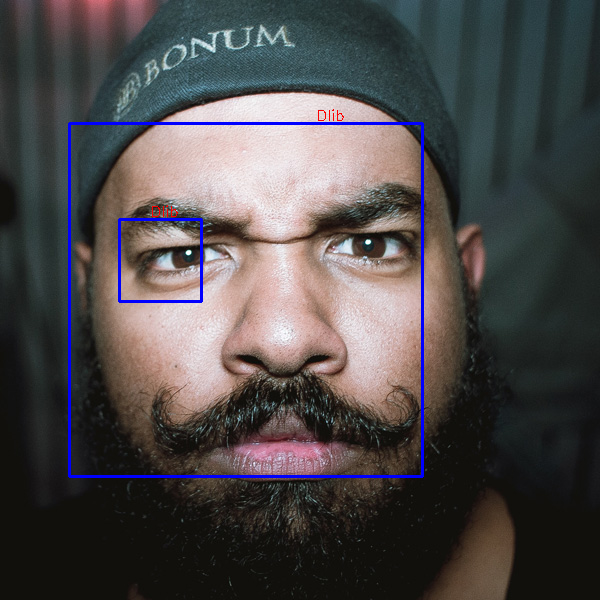

### (2) Face not detected 

#### training_images/real_00798.jpg

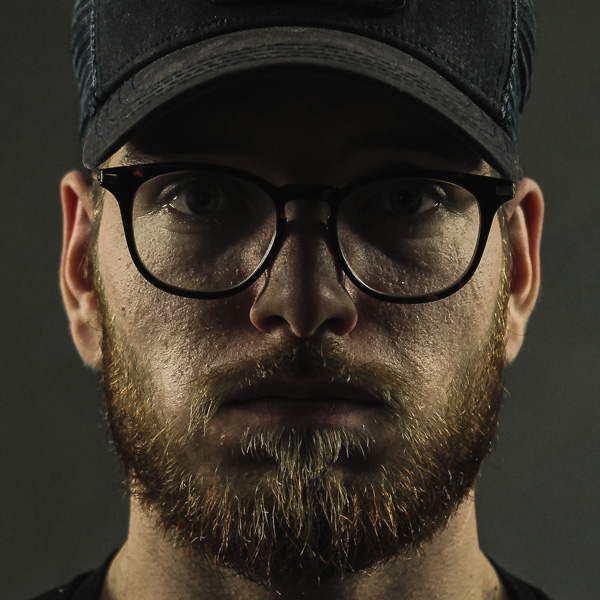

In [78]:
display(Markdown("### (1) Correctly detected 1 face"))
test_bb(dlib_img_box_df,"training_images/real_00808.jpg",title="Dlib")
display(Markdown("### (2) Incorrectly detected 2 face"))
test_bb(dlib_img_box_df,"training_images/real_00041.jpg",title="Dlib")
display(Markdown("### (2) Face not detected "))
show_face(dlib_undetected_images)

In [104]:
score_board = score_board.append(get_metrics(dlib_img_box_df,method="Dlib-CNN"),ignore_index=True)
score_board

Method True_Positive False_Positive  ... Precision    Recall        F1
0      Haar           930             75  ...  0.925373  0.852429  0.887405
1     MTCNN          1103             17  ...  0.984821  1.000000  0.992353
2  Dlib-CNN          1093              3  ...  0.997263  1.000000  0.998630

[3 rows x 7 columns]

#### Observations:
> 1. As we could see that the number of false positives are far lesser when compared to MTCNN i.e 3 where more than one face was detected. - False positives without any false negatives.
> 2. The method has an F1 score of ~99.8% which is 0.6% better than MTCNN approach.



### (4.2.8) Show all images which could not be detected by either Haar based method , MTCNN or Dlib based CNN method

#### training_images/real_00818.jpg

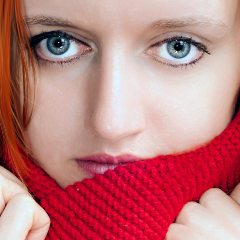

#### training_images/real_00951.jpg

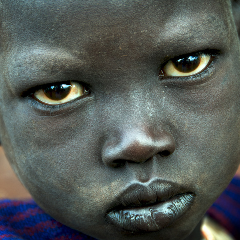

#### training_images/real_00692.jpg

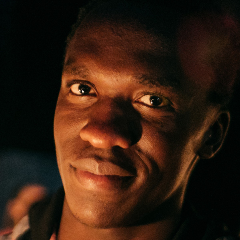

#### training_images/real_00798.jpg

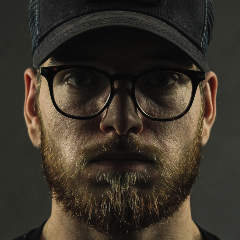

In [75]:
haar_set = set(haar_undetected_images)
mtcnn_set = set(mtcnn_undetected_images)
dlib_set = set(dlib_undetected_images)

# haar_set.intersection(mtcnn_set) , dlib_set.intersection(haar_set), mtcnn_set.intersection(dlib_set) 
show_face(haar_set.intersection(mtcnn_set),0.4)
show_face(dlib_set.intersection(haar_set),0.4)
show_face(mtcnn_set.intersection(dlib_set),0.4)

# (5) Conclusion
#### (1) Dlib based CNN is better than MTCNN  which in turn is better than Haar based method in performance but much slower than Haar based method. 
#### (2)  The present use case may not need as much speed but performance as these are static images. 
#### (3) Speed would be of essence in case where objects or faces have to be detected of a video capture or clip. Here, Dlib based method is faster and has better performance wehen compared to MTCNN or Haar based methods.
#### (4) Hence, we will choose Dlib based CNN over MTCNN or Haar based method to curate images with their bounding box attributes.
#### (5) Challenges fased with the images :
> 1. Face partailly covered.
> 2. Face tilted such that the frontal face is not completely visible.
> 3. Face turned away such that the frontal is not completely visible.
> 4. Face zoomed such that it crops part of the face.
> 5. Poor illumination or partially lit surfaces on the face.